In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

<h4>Data processing for machine learning algorithm</h4>

In [11]:
df=pd.read_csv('final_data.csv')
del df['Unnamed: 0']
del df['boolDeadRelations']
del df['age']
del df['isNoble']

df.set_index('name',inplace=True)

# get dummy varibles for ordinal varibles
culture_dummy=pd.get_dummies(df['culture'],prefix='Culture') #Nan value will be ingored automatically
df[culture_dummy.columns]=culture_dummy
del df['culture']

house_dummy=pd.get_dummies(df['house'],prefix='House')
df[house_dummy.columns]=house_dummy
del df['house']

identity_dummy=pd.get_dummies(df['identity'])
df[identity_dummy.columns]=identity_dummy
del df['identity']  
del df['lord']  #delete one column to eliminate the linear relationships

#get the attribute set and label set
X=df.drop('isAlive',axis=1)
Y=df['isAlive']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.15)


In [12]:
#just write the X,Y with the best accuracy

#X_train=pd.read_csv('X_train.csv',index_col='name')
#X_test=pd.read_csv('X_test.csv',index_col='name')
#Y_train=pd.read_csv('Y_train.csv',index_col='name').values.ravel()
#Y_test=pd.read_csv('Y_test.csv',index_col='name').values.ravel()

<h4>K_nearest neighbors algorithm</h4>

In [13]:
def validate_model(model,K,X,Y):    #cross validation
    folder=KFold(K,shuffle=True)
    folds=folder.split(X,Y)
    val_error=0.0
    fold_count=0
    for fold in folds:
        train_idx,val_idx=fold
        x_train=X.iloc[train_idx]
        y_train=Y[train_idx]
        x_val=X.iloc[val_idx]
        y_val=Y[val_idx]     
        model.fit(x_train,y_train)
        y_pred=model.predict(x_val)
        val_err=np.mean(y_val==y_pred)
        val_error+=val_err
        fold_count+=1
    return val_error/K

In [14]:
#choose the best k for the model
accuracy=np.array([])  
for k in range(3,20):
    base_model=KNeighborsClassifier(n_neighbors=k)
    score=validate_model(base_model,5,X_train,Y_train)  #use 5-fold
    accuracy=np.append(accuracy,score)

the best_k is 18
the accuracy of knn is 0.8082191780821918
[[ 19  14]
 [ 42 217]]


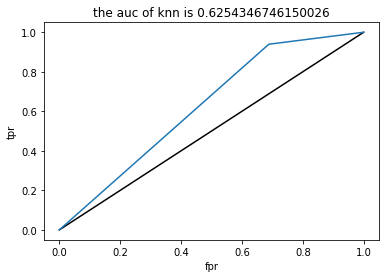

In [15]:
best_k=accuracy.argmax()+3
print(f'the best_k is {best_k}')
knn_best_model=KNeighborsClassifier(n_neighbors=best_k).fit(X_train,Y_train)
Y_pre=knn_best_model.predict(X_test)
print(f'the accuracy of knn is {np.mean(Y_pre==Y_test)}')
matrix=confusion_matrix(Y_pre,Y_test)
print(matrix)
(fpr, tpr, thresholds) = roc_curve(Y_test,Y_pre)
area = auc(fpr,tpr)
plt.title(f'the auc of knn is {area}')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr,tpr)

<h4>Naive Bayes<h4>

In [17]:
NB_model1 = MultinomialNB(alpha=1) #use Multinomial Naive Bayes, let alpha=1 (Laplace Smoothing)
NB_model1.fit(X_train,Y_train)
NB_model2 = BernoulliNB() #use BernouliNB to predict
NB_model2.fit(X_train,Y_train) 
print(accuracy_score(Y_test,NB_model1.predict(X_test)))
print(accuracy_score(Y_test,NB_model2.predict(X_test))) 
#contrast

0.815068493150685
0.8047945205479452


<h4>Decision Tree<h4>

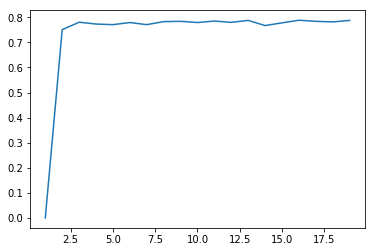

In [29]:
performance=np.repeat(0.0,19)
for k in range(2,20): #We are trying to find the best depth of the decision tree in case overfitting 
    decision_tree_model = tree.DecisionTreeClassifier(max_depth=k) 
    avg_performance=(validate_model(decision_tree_model,k,X_train,Y_train))
    performance[k-1]=avg_performance
outcomes=np.arange(1,20)
plt.plot(outcomes,performance)

In [31]:
decision_tree_model = tree.DecisionTreeClassifier(max_depth=10)
#Roughly, the best max depth is 10
decision_tree_model.fit(X_train,Y_train)
accuracy_score(y_test, decision_tree_model.predict(x_test))

0.8747433264887063

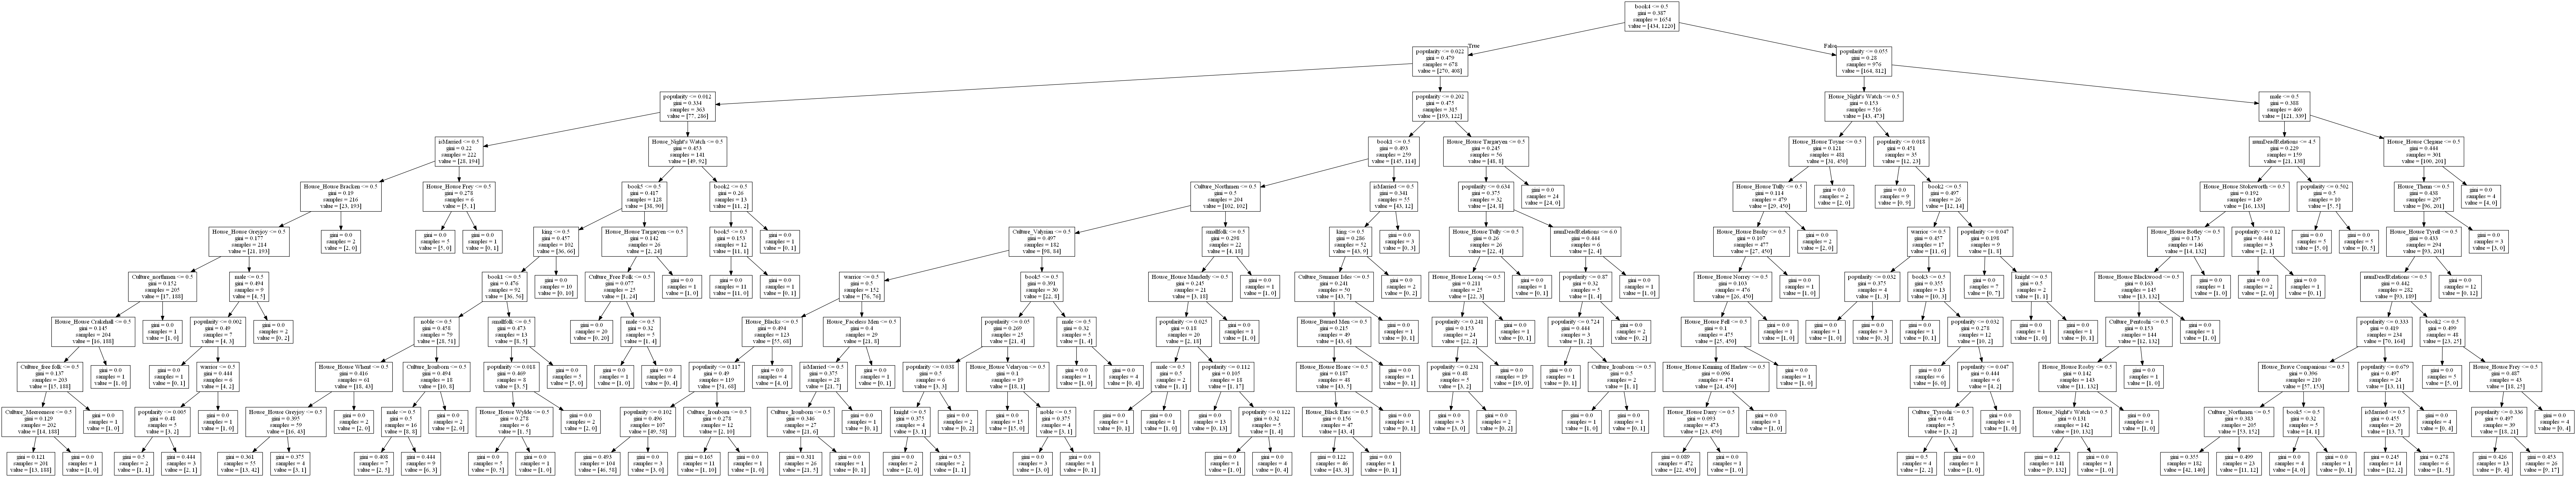

In [32]:
feature_names = [key for key in df if not key=='isAlive']
from IPython.display import Image
dot_data = tree.export_graphviz(decision_tree_model, out_file=None,feature_names=feature_names)
import pydotplus

graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

Image(graph.create_png())
#visualization 

<h4>Random Forrest<h4>

In [64]:
from sklearn.ensemble import RandomForestClassifier

RFC_model = RandomForestClassifier(n_estimators=10)
RFC_model.fit(X_train,Y_train)
accuracy_score(Y_test, RFC_model.predict(X_test))
#random forrest's algorithm

0.8082191780821918

<h4>SVM<h4>

In [37]:
from sklearn.svm import SVC

In [43]:
performance=np.repeat(0.0,50)
k=0
for c in np.arange(2,102,2):
    SVM_model = SVC(kernel='rbf',C=c,gamma='auto')
    SVM_model.fit(X_train,Y_train)
    performance[k]=accuracy_score(Y_test, SVM_model.predict(X_test))
    k+=1
#we will use this loop to determine c value(regularizaiton)

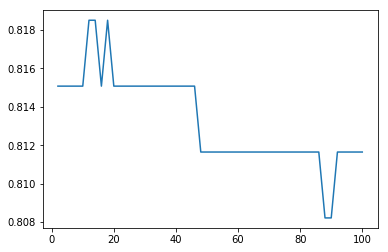

In [44]:
outcomes=np.arange(2,102,2)
plt.plot(outcomes,performance)

In [45]:
SVM_model = SVC(kernel='rbf',C=20,gamma='auto')
SVM_model.fit(X_train,Y_train)
accuracy_score(Y_test, SVM_model.predict(X_test))
#seems 20 is a good choise

0.815068493150685

In [46]:
confusion_matrix(Y_test,SVM_model.predict(X_test))

array([[ 10,  51],
       [  3, 228]], dtype=int64)

<h4>Logistic Regression</h4>

In [66]:
Logis_model=LogisticRegression(solver='liblinear').fit(X_train,Y_train)
y_pre=Logis_model.predict(X_test)
print(f'the accuracy of LogisticRegression is {np.mean(y_pre==Y_test)}')

the accuracy of LogisticRegression is 0.8116438356164384


<BarContainer object of 10 artists>

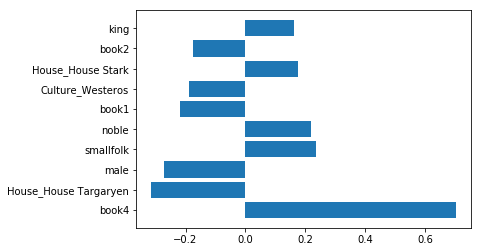

In [67]:
#calculate the importance of each attribute
feature_importance=Logis_model.coef_.ravel()*np.std(X_train,axis=0)
#find the most ten important factors
index=feature_importance[abs(feature_importance).argsort()[::-1][:10]].index
plt.barh(index,feature_importance[abs(feature_importance).argsort()[::-1][:10]])

[[ 22  16]
 [ 39 215]]


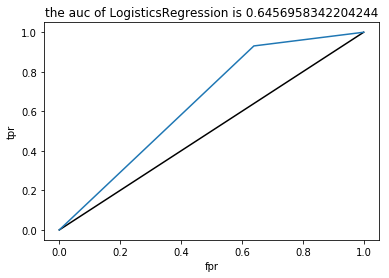

In [68]:
matrix=confusion_matrix(y_pre,Y_test)
print(matrix)
(fpr, tpr, thresholds) = roc_curve(Y_test,y_pre)
area = auc(fpr,tpr)
plt.title(f'the auc of LogisticsRegression is {area}')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr,tpr)

<h4>Predict the death probability for the main characters</h4>

In [84]:
#Get the data we need to predict
name=['Sansa Stark','Tyrion Lannister','Jon Snow','Daenerys Targaryen','Jaime Lannister','Bran Stark', 'Arya Stark','Cersei Lannister']
X_prediction=df.loc[name].drop('isAlive',axis=1)
Y_prediction=df.loc[name]['isAlive']
death_prob=Logis_model.predict_proba(X_prediction)
pd.DataFrame(death_prob,index=name,columns=['Death','Alive']).sort_values(by='Death')

,Death,Alive
Sansa Stark,0.381648,0.618352
Arya Stark,0.409342,0.590658
Jon Snow,0.440132,0.559868
Bran Stark,0.522227,0.477773
Cersei Lannister,0.742393,0.257607
Jaime Lannister,0.754733,0.245267
Daenerys Targaryen,0.866069,0.133931
Tyrion Lannister,0.873692,0.126308


<h4>Try to use oversampling to modify the imbalanced dataset

In [77]:
#use random oversample to modify the data
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
ros = RandomOverSampler()
X_train_oversample, Y_train_oversample = ros.fit_sample(X_train, Y_train)
print(X_train.shape)
print(X_train_oversample.shape)
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression(solver='liblinear'))
scores = cross_validate(oversample_pipe,
                        X_train, Y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(1654, 382)
(2440, 382)


(0.7636383131736735, 0.894489157718519)

In [78]:
#use smote method to modify the data
oversample_pipe = make_imb_pipeline(SMOTE(), LogisticRegression(solver='liblinear'))
scores = cross_validate(oversample_pipe,
                        X_train, Y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.7606173968044917, 0.8917600265011073)